# Classifying Palmer Penguins
## Kate Kenny 
### CS 0451

In this blog post, we will explore how different models can be used to classify species of penguins in the Palmer Penguin data set and visualize both our results and some of the decisions that went into the models. 

### Importing Training Data and Exploring Trends
First, let's load our training data into a pandas dataframe and prepare it to be analyzed. Then, we will explore some general trends to see what features could be useful to use in predictions and what kinds of models could be effective to classify the penguin species.

In [35]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

#Prepare Data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

X_train


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,41.1,17.5,190.0,3900.0,8.94365,-26.06943,0,1,0,1,0,1,0,1
270,45.4,14.6,211.0,4800.0,8.24515,-25.46782,1,0,0,1,0,1,1,0
271,36.2,17.2,187.0,3150.0,9.04296,-26.19444,0,0,1,1,1,0,1,0
272,50.0,15.9,224.0,5350.0,8.20042,-26.39677,1,0,0,1,0,1,0,1


### Exploring and Visualizing the Training Data

Below is a scatterplot of penguin body mass compared to flipper length. The points in this plot are colored by species, as seen in the legend. This plot highlights that there seems to be some trends in body mass and flipper length by species but the Adelie and Chinstrap penguins are quite similar while the Gentoo penguins have higher body mass and flipper length. This could indicate that these features could be very good at predicting whether or not a penguin is Gentoo or not, but for the model to be effective we would need some other features to differentiate between the other two species. 

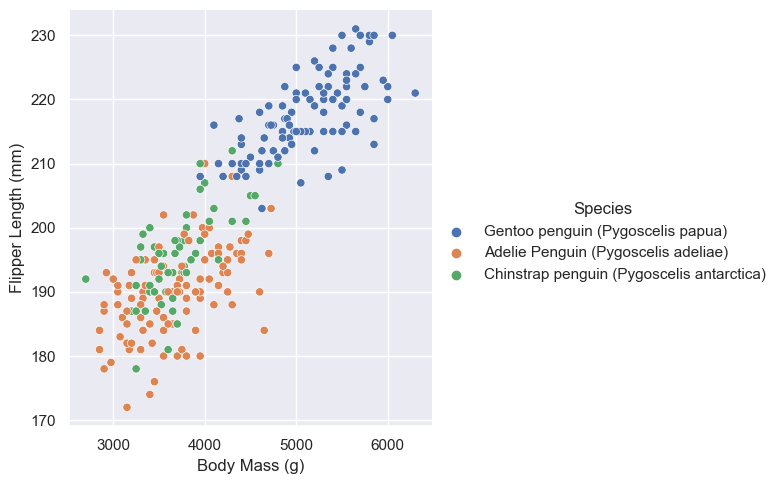

In [18]:
import seaborn as sns

sns.set_theme()

sns.relplot(data = train, 
           x = "Body Mass (g)", 
           y = "Flipper Length (mm)", 
           hue = "Species")

### Penguin population by species and Island
Next, let's consider the below table which displays the number of penguines on each island by species. This is an interesting category to examine since two of the penguin species (Gentoo and Chinstrap) were only recorded on one island each while Adelie penguins were found on all three. This could be relevant to our prediction models since it could be easy to eliminate possible species when making predictions based on the island on which they were found. This leads me to believe Island will be a useful qualitative feature for our model.

In [32]:
train.groupby(["Species", "Island"])[["Species"]].count()

Species
Species                                   Island            
Adelie Penguin (Pygoscelis adeliae)       Biscoe          35
                                          Dream           41
                                          Torgersen       42
Chinstrap penguin (Pygoscelis antarctica) Dream           56
Gentoo penguin (Pygoscelis papua)         Biscoe         101

### Choosing features and models

First, we want to select features that will lead to the best possible predictions from our model. To do this, we can use the Scikit Learn function SelectKBest which returns the specified number (k) of features that will result in the best prediction. 

So, below the code selects the best two quantitative and one qualitative feature to use in the modelling process later. 

In [117]:

#choose features and do cross validation NEED CROSS VALIDATION STILL

from itertools import combinations
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

all_qual_cols = ["Clutch Completion_No", "Clutch Completion_Yes", "Sex_FEMALE", "Sex_MALE", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]
all_quant_cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]

#Select 2 quantitative columns
select_best = SelectKBest(score_func = f_classif, k=2)
train_new = select_best.fit_transform(X_train[all_quant_cols], y_train)

filter = select_best.get_support()
quant_best = X_train[all_quant_cols].columns[filter]

#Select 1 qualitative feature (NEED TO AUTOMATE CHOOSING THE PAIR)
select_best = SelectKBest(score_func = f_classif, k=1)
train_new = select_best.fit_transform(X_train[all_qual_cols], y_train)

filter = select_best.get_support()
qual_best = X_train[all_qual_cols].columns[filter]

#create list of all selected features
best_feat = [quant_best[0], quant_best[1], qual_best[0]]


Index(['Culmen Length (mm)', 'Flipper Length (mm)'], dtype='object')
Index(['Island_Biscoe'], dtype='object')
['Culmen Length (mm)', 'Flipper Length (mm)', 'Island_Biscoe']


### Model Choices

From here, we can use the columns selected above to run a logistic regression model on the training data. 

/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/katekenny/opt/anaconda3/

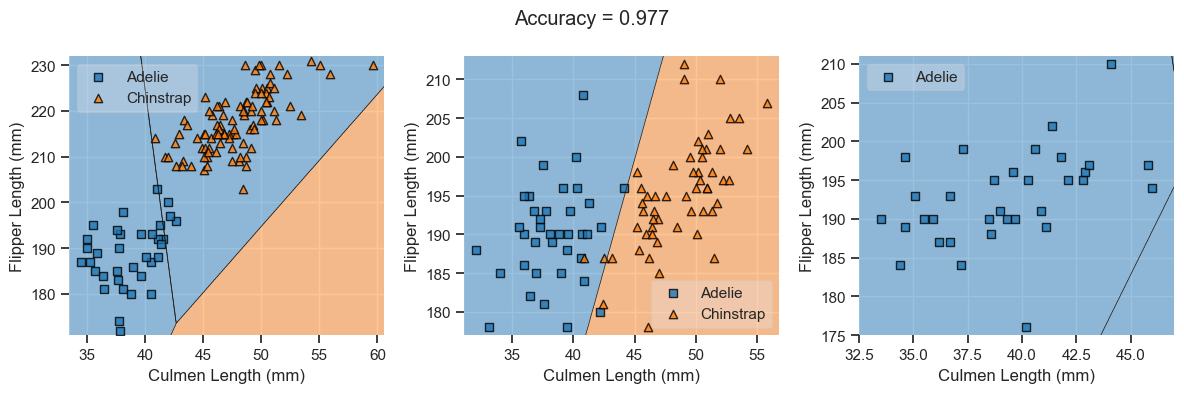

In [133]:
from sklearn.linear_model import LogisticRegression

cols = ["Culmen Length (mm)", "Flipper Length (mm)", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

#Plotting decision regions
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt
import numpy as np

def decision_region_panel(X, y, model, qual_features):  
  p = len(qual_features)
  fig, axarr = plt.subplots(1, p, figsize=(4*p,4))
  for i in range(p):

      filler_feature_values = {2+j: 0 for j in range(p)}

      filler_feature_values.update({2+i: 1})

      ix = X[qual_features[i]] == 1

      ax = axarr[i]

      plot_decision_regions(np.array(X[ix]), y[ix], clf=model,
                            filler_feature_values=filler_feature_values,
                            filler_feature_ranges={2+j: 0.1 for j in range(p)},
                            legend=2, ax=ax)

      ax.set_xlabel(X.columns[0])
      ax.set_ylabel(X.columns[1])

      handles, labels = ax.get_legend_handles_labels()
      ax.legend(handles, 
          ["Adelie", "Chinstrap", "Gentoo"], 
           framealpha=0.3, scatterpoints=1)

  # Adding axes annotations
  fig.suptitle(f'Accuracy = {model.score(X, y).round(3)}')
  plt.tight_layout()
  plt.show()

qual_features = ["Island_Biscoe", "Island_Dream", "Island_Torgersen"]
decision_region_panel(X_train[cols], y_train, LR, qual_features)